### Install Requirement
The following python package is needed for running this code:
*   matplotlib
*   numpy
*   pandas
*   scipy
*   scikit-learn
*   pytorch

On TACC (frontera especially), the pytorch need to install from pip and need to load modules for gpu support, one tested command block to install pytorch on Frontera is:
```
module load cuda cudnn
pip install h5py
pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f
```

In [9]:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader,Dataset
from matplotlib import pyplot as plt

# Important: Change it to TACC machine data location
data_location = "/mnt/storage/tmwang/Materials/MP_v1.mat"

In [2]:
# define cohesive energy prediction model
class MLP_2layer(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super(MLP_2layer, self).__init__()
        self.input = input_dim
        self.hidden = hidden_dim
        self.output = out_dim
        self.fc1 = nn.Linear(self.input, self.hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden, self.output)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out



# define VAE model
class SimpleVAE(nn.Module):
    """
    Simple VAE
    """
    def __init__(self, input_dim, hidden_dim, latent_dim, energy=True):
        super(SimpleVAE, self).__init__()
        self.input = input_dim
        self.hidden = hidden_dim
        self.latent = latent_dim
        self.contain_energy_prediction = energy
        self.fc1 = nn.Linear(self.input, self.hidden)
        self.dropout = nn.Dropout(p=0.25)
        self.relu1 = nn.ReLU()
        self.fc21 = nn.Linear(self.hidden, self.latent)
        self.fc22 = nn.Linear(self.hidden, self.latent)
        self.fc3 = nn.Linear(self.latent, self.hidden)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(self.hidden, self.input)
        self.energy_model = MLP_2layer(self.latent, int(self.latent/2), 1)

    def encode(self, x):
        out = self.relu1(self.dropout(self.fc1(x)))
        return self.fc21(out), self.fc22(out)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        out = self.relu2(self.fc3(z))
        return self.fc4(out)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        if self.contain_energy_prediction:
            return self.decode(z), mu, logvar, z, self.energy_model(z)
        else:
            return self.decode(z), mu, logvar, z
    
    def latent_space(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z

# define auxiliary dataset class
class ndarrayDataset(Dataset):
    """simple dataset"""

    def __init__(self, X, y):
        super(ndarrayDataset, self).__init__()
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
# define loss function here, the MAPE are set as criterion for cohesive energy prediction
def simplevae_elbo_loss_function_with_energy(recon_x, x, mu, logvar, pred_e, e):
    MSE = nn.MSELoss(reduction='mean')(recon_x, x)
    MAPE_eng = torch.sum(torch.abs((pred_e-e)/e))
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 0.1 * MSE + MAPE_eng + 0.01 * KLD, MSE, MAPE_eng, KLD

In [7]:
# load data (version 1)
data = sio.loadmat(data_location)

input_mat = data['MP']
id = input_mat[:,0]
atom_type = input_mat[:,1]
energy = input_mat[:,2] # target value
X = input_mat[:,3:] # training data
y = energy

X_train, X_test, y_train, y_test, l_train, l_test, id_train, id_test = train_test_split(X, y, atom_type, id, test_size=0.20, shuffle=True, random_state=9)



In [4]:

# add some parameters
class Args:
    batch_size = 256 #input batch size for training (default: 256)
    # shrink total iteration times (epochs) here to stop the program earlier
    epochs = 100 #number of epochs to train (default: 100)
    no_cuda = False
    seed = 9 # random seed (default: 9)
    log_interval = 10 # how many batches to wait before logging training status (default 10)
    gpu = 0 # gpu card id (default: 0)

args=Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda:%d" % args.gpu if args.cuda else "cpu")

train_dataset = ndarrayDataset(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size = args.batch_size, shuffle=True)
train_losses = np.zeros((args.epochs))
test_dataset = ndarrayDataset(X_test,y_test)
test_loader = DataLoader(test_dataset, batch_size=1000)
test_losses = np.zeros((args.epochs))

model = SimpleVAE(3600,200,40).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)


"""

Body part of train/test

"""

def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.view(-1,1).to(device)
        optimizer.zero_grad()
        x_pred, mu, logvar, _, y_pred = model(data)
        loss, _, eng_loss, _ = simplevae_elbo_loss_function_with_energy(x_pred, data, mu, logvar, y_pred, y)
        train_loss += (eng_loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t MAPE Loss/Total Loss: {:.6f}/{:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), eng_loss.item()/ len(data),
                loss.item() / len(data)))

    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average MAPE loss: {:.4f}'.format(epoch, train_loss))
    return train_loss


def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, y) in enumerate(test_loader):
            data = data.to(device)
            y = y.view(-1,1).to(device)
            x_pred, mu, logvar, _, y_pred = model(data)
            _, _, eng_loss, _,= simplevae_elbo_loss_function_with_energy(x_pred, data, mu, logvar, y_pred, y)
            test_loss += (eng_loss.item())
            #pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set MAPE loss: {:.4f}'.format(test_loss))
    return test_loss

train_err_list = []
test_err_list = []
for epoch in range(1, args.epochs + 1):
    train_err = train(epoch)
    test_err = test(epoch)
    train_err_list.append(train_err)
    test_err_list.append(test_err)

# The program will save the data for plotting and recovery of modeling
# This part saves the MAPE loss in each epoch
with open('MAPE_simpleVAE_%d.npz' % args.epochs,'wb') as f:
    np.savez(f, train_err = train_err_list, test_err = test_err_list)
torch.save(model.state_dict(),'model_simpleVAE_%d.pth' % args.epochs)


27/0.680739
Train Epoch: 82 [10240/32880 (31%)]	 MAPE Loss/Total Loss: 0.530944/0.662737
Train Epoch: 82 [12800/32880 (39%)]	 MAPE Loss/Total Loss: 0.537096/0.632113
Train Epoch: 82 [15360/32880 (47%)]	 MAPE Loss/Total Loss: 0.589713/0.675800
Train Epoch: 82 [17920/32880 (54%)]	 MAPE Loss/Total Loss: 0.587931/0.667163
Train Epoch: 82 [20480/32880 (62%)]	 MAPE Loss/Total Loss: 0.637064/0.721029
Train Epoch: 82 [23040/32880 (70%)]	 MAPE Loss/Total Loss: 0.717659/0.814350
Train Epoch: 82 [25600/32880 (78%)]	 MAPE Loss/Total Loss: 0.593044/0.665635
Train Epoch: 82 [28160/32880 (85%)]	 MAPE Loss/Total Loss: 0.564965/0.622861
Train Epoch: 82 [30720/32880 (93%)]	 MAPE Loss/Total Loss: 0.584352/0.649655
====> Epoch: 82 Average MAPE loss: 0.5956
====> Test set MAPE loss: 0.5732
Train Epoch: 83 [0/32880 (0%)]	 MAPE Loss/Total Loss: 0.523198/0.593899
Train Epoch: 83 [2560/32880 (8%)]	 MAPE Loss/Total Loss: 0.577546/0.660458
Train Epoch: 83 [5120/32880 (16%)]	 MAPE Loss/Total Loss: 0.545635/0.6242

Max mape: 86.4651  Average mape: 0.5752
Max mape: 32.8328  Average mape: 0.5717


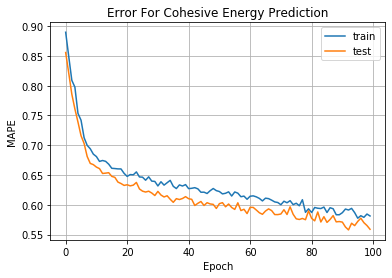

<Figure size 432x288 with 0 Axes>

In [10]:
# Evaluation part
import pandas as pd

# Uncomment these two lines to load a past trained network
# otherwise the model in the last block will be used
"""
model.load_state_dict(torch.load('model_simpleVAE_100.pth'))
model.to(device)
"""



# Check last epoch's mape for each individual data and record in csv files
mapes = 0.
max_mapes = 0.
rowlist = []
for batch_idx, (data, y) in enumerate(train_dataset):
    data = data.to(device)
    y = y.view(-1,1).to(device)
    #y_pred = model(data)
    _,_,_,_,y_pred = model(data)
    mape = torch.abs((y-y_pred)/y).item()
    rowlist.append(dict({
        "material_id" : id_train[batch_idx],
        "cohesive eng.":y.cpu().numpy()[0][0],
        "predicted cohesive eng.":y_pred.detach().cpu().numpy()[0],
        "mape":mape
    }))
    max_mapes = max(max_mapes, mape)
    mapes += mape

print("Max mape: %.4f  Average mape: %.4f" % (max_mapes, mapes/len(train_dataset)))

df = pd.DataFrame(rowlist, columns= ["material_id", "cohesive eng.", "predicted cohesive eng.", "mape"])
df.to_csv('train_VAE.csv', index=False)

mapes = 0
max_mapes = 0
rowlist = []
for batch_idx, (data, y) in enumerate(test_dataset):
    data = data.to(device)
    y = y.view(-1,1).to(device)
    #y_pred = model(data)
    _,_,_,_,y_pred = model(data)
    mape = torch.abs((y-y_pred)/y).item()
    rowlist.append(dict({
        "material_id": id_test[batch_idx],
        "cohesive eng.": y.cpu().numpy()[0][0],
        "predicted cohesive eng.": y_pred.detach().cpu().numpy()[0],
        "mape": mape
    }))
    max_mapes = max(max_mapes, mape)
    mapes += mape

print("Max mape: %.4f  Average mape: %.4f" % (max_mapes, mapes/len(test_dataset)))

df = pd.DataFrame(rowlist, columns= ["material_id", "cohesive eng.", "predicted cohesive eng.", "mape"])
df.to_csv('test_VAE.csv', index=False)

# Uncomment these lines if you wish to plot the past record
"""
with open('MAPE_simpleVAE_100.npz','rb') as f:
    data = np.load(f)
    train_err_list = data['train_err']
    test_err_list = data['test_err']
"""
# plot average MAPE over all iterations
plt.title("Error For Cohesive Energy Prediction")
plt.plot(train_err_list, label='train')
plt.plot(test_err_list, label='test')
plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.grid()
plt.legend()
plt.show()
plt.savefig('simpleVAE_mape.png') # can be saved as .svg file
